In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import tqdm
import requests
import multiprocessing as mp
from p_tqdm import p_map
import time
%matplotlib inline

In [2]:
from random_user_agent.user_agent import UserAgent
from random_user_agent.params import SoftwareName, OperatingSystem, Popularity

software_names = [SoftwareName.CHROME.value]
operating_systems = [OperatingSystem.WINDOWS.value, OperatingSystem.LINUX.value]   
popularity = [Popularity.POPULAR.value]
user_agent_rotator = UserAgent(software_names=software_names, operating_systems=operating_systems, popularity=popularity, limit=10)

user_agents = [item['user_agent'] for item in user_agent_rotator.get_user_agents()]
uagent = user_agents[0]

In [3]:
def epoch_to_local(timestr):
    return time.strftime('%d-%m-%Y %H:%M:%S', time.localtime(int(timestr))) #matches tweets' time as long as user is on CET time

def tweets_from_search(response):
    soup = BeautifulSoup(response.text, 'html.parser')
    metadata = [(item["data-conversation-id"], epoch_to_local(item.span["data-time"]))\
                for item in soup.find_all("a", class_="tweet-timestamp js-permalink js-nav js-tooltip")]
    text = [item.getText() for item in soup.find_all("p", class_="TweetTextSize js-tweet-text tweet-text")]
    return list(zip(metadata, text))

# I. RER B

## a) Single Thread

The next cell returns False if your combination of IP+user-agent is shadowbanned by Twitter.

In [4]:
headers = {
    'authority': 'twitter.com',
    'dnt': '1',
    'upgrade-insecure-requests': '1',
    'user-agent': uagent,
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'sec-fetch-site': 'none',
    'sec-fetch-mode': 'navigate',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,ru;q=0.6,de;q=0.5,pt;q=0.4',
}

params = [
    ('q', 'from:RERB exclude:replies since:2017-10-04  until:2017-10-05'),
    ('src', 'typed_query'),
    ('f', 'tweets'),
    ('lang', 'fr'),
]

response = requests.get('https://twitter.com/search', headers=headers, params=params)
soup = BeautifulSoup(response.text, 'html.parser')
bool(soup.find_all("p", class_="TweetTextSize js-tweet-text tweet-text"))

True

In [63]:
dates = list(pd.date_range(start='1/1/2019', end='1/31/2019').strftime("%Y-%m-%d"))[::-1]
out = []
for i in tqdm(range(len(dates)-1)):
    params[0] = ('q', 'from:RERB exclude:replies since:'+dates[i+1]+'  until:'+dates[i])
    response = requests.get('https://twitter.com/search', headers=headers, params=params)
    out = out + tweets_from_search(response)

100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


In [31]:
def get_tweets_rerb_single(start, end):
    dates = list(pd.date_range(start=start, end=end).strftime("%Y-%m-%d"))[::-1]
    out = []
    for i in range(len(dates)-1):
        params[0] = ('q', 'from:RERB exclude:replies since:'+dates[i+1]+'  until:'+dates[i])
        response = requests.get('https://twitter.com/search', headers=headers, params=params)
        out = out + tweets_from_search(response)
    return out

In [34]:
%timeit get_tweets_rerb_single(start='1/1/2019', end='1/31/2019')

22 s ± 8.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## b) Multi-thread

In [98]:
def get_tweets_between(dates, uagent): #dates=(date0, date1) where date0 > date1. Choosing consecutive days prevents omissions from missing scrolling
    headers = {
    'authority': 'twitter.com',
    'dnt': '1',
    'upgrade-insecure-requests': '1',
    'user-agent': uagent,
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'sec-fetch-site': 'none',
    'sec-fetch-mode': 'navigate',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,ru;q=0.6,de;q=0.5,pt;q=0.4',
    }

    params = [
    ('q', 'from:RERB exclude:replies since:2017-10-04  until:2017-10-05'),
    ('src', 'typed_query'),
    ('f', 'tweets'),
    ('lang', 'fr'),
    ]
    
    params[0] = ('q', 'from:RERB exclude:replies since:'+dates[1]+'  until:'+dates[0])
    response = requests.get('https://twitter.com/search', headers=headers, params=params)
    return tweets_from_search(response)

In [101]:
dates_temp = list(pd.date_range(start='1/1/2019', end='1/31/2019').strftime("%Y-%m-%d"))[::-1]
dates = []
for i in range(len(dates_temp)-1):
    dates.append((dates_temp[i], dates_temp[i+1]))
    
results = p_map(get_tweets_between, dates, uagent)
results = [(item[0][0], item[0][1], item[1]) for sublist in results for item in sublist]



  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:00<00:25,  1.14it/s]

 53%|█████▎    | 16/30 [00:01<00:08,  1.63it/s]

 67%|██████▋   | 20/30 [00:01<00:04,  2.24it/s]

100%|██████████| 30/30 [00:01<00:00, 21.49it/s]


In [39]:
def get_tweets_rerb_multi(start, end, ncpu):
    dates_temp = list(pd.date_range(start=start, end=end).strftime("%Y-%m-%d"))[::-1]
    dates = []
    for i in range(len(dates_temp)-1):
        dates.append((dates_temp[i], dates_temp[i+1]))
    pool = mp.Pool(processes=ncpu)
    results = pool.map(get_tweets_between, dates)
    results = [(item[0][0], item[0][1], item[1]) for sublist in results for item in sublist]
    return results

In [41]:
%timeit get_tweets_rerb_multi(start='1/1/2019', end='1/31/2019', ncpu=16)

The slowest run took 4.01 times longer than the fastest. This could mean that an intermediate result is being cached.
2.18 s ± 1.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
len(results)

244

In [43]:
results[-1]

('1080242629969932290',
 '02-01-2019 00:21:27',
 '00:19, le trafic est interrompu entre Denfert et Laplace. Reprise estimée à 01:30. (accident grave de personne)  #RERB')

In [44]:
results[2]

('1090330404844916737',
 '29-01-2019 20:26:40',
 "(Panne de signalisation au Parc des Expositions): fin d'incident, le trafic reprend progressivement entre les gares de l'aéroport Charles-de-Gaulle et Aulnay. Le trafic #RERB reste perturbé sur l'ensemble de la ligne")

# II. Toutes lignes confondues

In [8]:
def get_tweets_handle_between(tupl):
    (handle, dates, uagent) = tupl
    headers = {
    'authority': 'twitter.com',
    'dnt': '1',
    'upgrade-insecure-requests': '1',
    'user-agent': uagent,
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
    'sec-fetch-site': 'none',
    'sec-fetch-mode': 'navigate',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9,fr-FR;q=0.8,fr;q=0.7,ru;q=0.6,de;q=0.5,pt;q=0.4',
    }

    params = [
    ('q', 'from:RERB exclude:replies since:2017-10-04  until:2017-10-05'),
    ('src', 'typed_query'),
    ('f', 'tweets'),
    ('lang', 'fr'),
    ]
    
    params[0] = ('q', 'from:'+handle+' exclude:replies since:'+dates[1]+'  until:'+dates[0])
    response = requests.get('https://twitter.com/search', headers=headers, params=params)
    return tweets_from_search(response)

In [9]:
handles = ["rer_a", "rerb", "rerc_sncf", "rerd_sncf", "rere_sncf"]+["ligne"+str(i)+"_ratp" for i in range(1,15)]
df = pd.DataFrame(columns=['id', 'date', 'ligne', 'tweet'])
dates_temp = list(pd.date_range(start='1/1/2013', end='12/31/2019').strftime("%Y-%m-%d"))[::-1]
dates = []
for i in range(len(dates_temp)-1):
    dates.append((dates_temp[i], dates_temp[i+1]))
                  
for handle in handles:
    pool = mp.Pool(processes=16)
    to_process = [(handle, date, uagent) for date in dates]
    results = list(tqdm.tqdm_notebook(pool.imap(get_tweets_handle_between, to_process), total=len(to_process)))
    #results = pool.map(get_tweets_handle_between, ((handle, date, uagent) for date in dates))
    results = [(item[0][0], item[0][1], item[1]) for sublist in results for item in sublist]
    df_temp = pd.DataFrame(results, columns = ['id', 'date', 'tweet'])
    df_temp['ligne'] = handle
    df = pd.concat([df, df_temp])
    print(handle, 'done')
df = df.reset_index()

/Users/gabrielromon/.pyenv/versions/3.6.8/envs/ml-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



rer_a done


/Users/gabrielromon/.pyenv/versions/3.6.8/envs/ml-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()



rerb done



rerc_sncf done



rerd_sncf done



rere_sncf done



ligne1_ratp done



ligne2_ratp done



ligne3_ratp done



ligne4_ratp done



ligne5_ratp done



ligne6_ratp done



ligne7_ratp done



ligne8_ratp done



ligne9_ratp done



ligne10_ratp done



ligne11_ratp done



ligne12_ratp done



ligne13_ratp done



ligne14_ratp done


In [11]:
import pickle
with open("df.pickle", "wb") as f:
    pickle.dump(df, f)

In [12]:
import pickle
with open("df.pickle", "rb") as f:
    df = pickle.load(f)

In [13]:
df

,index,date,id,ligne,tweet
0,0,08-12-2019 17:41:29,1203716235441123333,rer_a,[Mouvement Social] Prévisions de trafic pour ...
1,1,07-12-2019 18:14:34,1203362173256421377,rer_a,[Mouvement Social] Prévisions de trafic pour ...
2,2,06-12-2019 19:25:03,1203017524742434817,rer_a,Dernier départ de Nanterre–Préfecture vers Ce...
3,3,06-12-2019 19:25:03,1203017524423643137,rer_a,Dernier départ de Nanterre–Préfecture vers Po...
4,4,06-12-2019 18:40:04,1203006205289009153,rer_a,Dernier départ de Poissy terminus Nanterre–Pr...
...,...,...,...,...,...
176831,5810,31-01-2013 06:00:57,296845501796610049,ligne14_ratp,"la @Ligne6_RATP, la @Ligne12_RATP, la @Ligne13..."
176832,5811,31-01-2013 06:00:31,296845391956172800,ligne14_ratp,"Vous pouvez également suivre la @Ligne1_RATP, ..."
176833,5812,31-01-2013 06:00:13,296845315598860289,ligne14_ratp,"Ouvert de 6h à 21h, il est animé par les infor..."
176834,5813,31-01-2013 05:59:56,296845245486862336,ligne14_ratp,Ce compte a vocation à vous renseigner sur l’é...


In [14]:
df[df['ligne']=='rerb']

,index,date,id,ligne,tweet
18793,0,08-12-2019 21:06:15,1203767769575104512,rerb,[Mouvement social]\n#RERB Trafic très fortemen...
18794,1,08-12-2019 17:52:22,1203718976053895169,rerb,[Mouvement Social] Lundi 9 décembre : le traf...
18795,2,08-12-2019 15:45:01,1203686927611895808,rerb,[Mouvement social]\n#RERB Trafic très fortemen...
18796,3,08-12-2019 14:58:30,1203675219753353217,rerb,[Mouvement social] #RERB \nTrafic très forteme...
18797,4,08-12-2019 14:22:42,1203666211831201800,rerb,Fin d'intervention des équipes techniques repr...
...,...,...,...,...,...
31912,13119,26-08-2013 19:32:58,372049043188236288,rerb,"En raison de la présence d'un colis suspect, l..."
31913,13120,26-08-2013 11:24:59,371926237381283840,rerb,Le trafic sera interrompu en semaine à partir ...
31914,13121,26-08-2013 11:24:20,371926072519954433,rerb,Modernisation du #RERB : dernière semaine de t...
31915,13122,26-08-2013 06:01:34,371844846735998976,rerb,Abonnez-vous au fil #Twitter @RERB et suivez t...


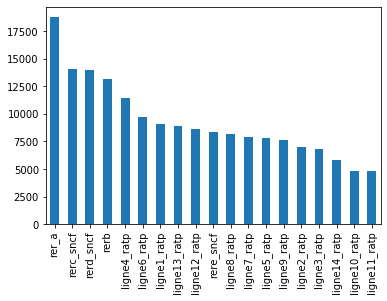

In [15]:
df["ligne"].value_counts().plot(kind='bar')

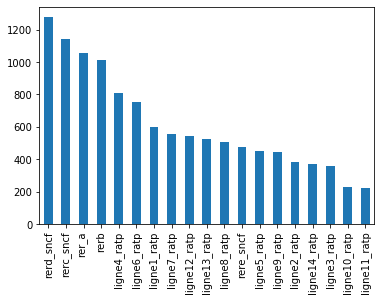

In [16]:
df[df['tweet'].str.contains('[Rr]epris', regex=True)]["ligne"].value_counts().plot(kind='bar')

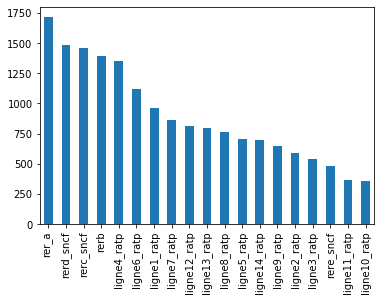

In [17]:
df[df['tweet'].str.contains('[Ii]nterrompu', regex=True)]["ligne"].value_counts().plot(kind='bar')

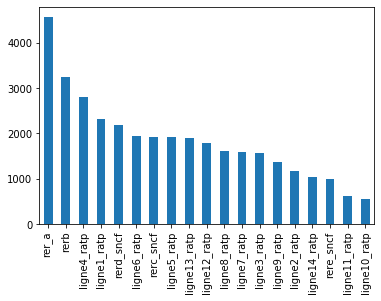

In [18]:
df[df['tweet'].str.contains('[Ii]ncident', regex=True)]["ligne"].value_counts().plot(kind='bar')

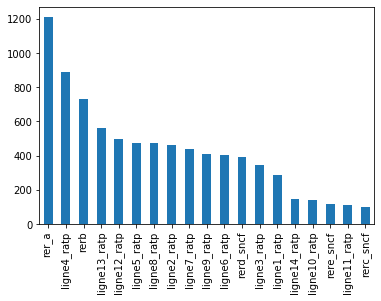

In [19]:
df[df['tweet'].str.contains('[Mm]alaise voyageur', regex=True)]["ligne"].value_counts().plot(kind='bar')